# Vanilla elo

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use("ggplot")

In [2]:
from datetime import datetime, timedelta
from collections import defaultdict

In [3]:
## load data
raw_data = pd.read_csv("/Users/tejaswin.p/Downloads/data_nbaallelo.csv", )
print "Total rows:", len(raw_data)
print "Total columns:", len(raw_data.columns)

Total rows: 126314
Total columns: 23


In [4]:
raw_data.columns

Index([u'gameorder', u'game_id', u'lg_id', u'_iscopy', u'year_id',
       u'date_game', u'seasongame', u'is_playoffs', u'team_id', u'fran_id',
       u'pts', u'elo_i', u'elo_n', u'win_equiv', u'opp_id', u'opp_fran',
       u'opp_pts', u'opp_elo_i', u'opp_elo_n', u'game_location',
       u'game_result', u'forecast', u'notes'],
      dtype='object')

In [5]:
df_data = raw_data[[u'gameorder', u'game_id', u'lg_id', u'_iscopy', u'year_id',
       u'date_game', u'seasongame', u'is_playoffs', u'team_id', u'fran_id',
       u'pts', u'opp_id', u'opp_fran',
       u'opp_pts', u'game_location',
       u'game_result']][raw_data._iscopy==0].copy()

In [6]:
print "Data:", df_data.shape

Data: (63157, 16)


In [7]:
df_data.date_game.head(10)

0     11/1/1946
2     11/2/1946
4     11/2/1946
7     11/2/1946
9     11/2/1946
11    11/3/1946
12    11/4/1946
14    11/5/1946
17    11/5/1946
19    11/7/1946
Name: date_game, dtype: object

In [8]:
_d = "11/1/1946"
def string_to_datetime(dstring):
    m, d, y = dstring.strip().split('/')
    return datetime(int(y), int(m), int(d))

In [9]:
df_data["game_datetime"] = df_data.date_game.map(string_to_datetime)

### Tracking the franchises through time.

In [10]:
df_data[["lg_id", "team_id", "fran_id", "year_id"]].drop_duplicates().sort_values(["fran_id", "year_id"]).head(10)

,lg_id,team_id,fran_id,year_id
702,NBA,BLB,Baltimore,1948
1137,NBA,BLB,Baltimore,1949
1909,NBA,BLB,Baltimore,1950
3079,NBA,BLB,Baltimore,1951
3841,NBA,BLB,Baltimore,1952
4562,NBA,BLB,Baltimore,1953
5296,NBA,BLB,Baltimore,1954
9,NBA,STB,Bombers,1947
734,NBA,STB,Bombers,1948
1151,NBA,STB,Bombers,1949


In [11]:
teams = set(df_data.fran_id).union(set(df_data.opp_fran))
print "Total different franchises:", len(teams)

Total different franchises: 53


### Computing elo.

In [12]:
df_data.head()

,gameorder,game_id,lg_id,_iscopy,year_id,date_game,seasongame,is_playoffs,team_id,fran_id,pts,opp_id,opp_fran,opp_pts,game_location,game_result,game_datetime
0,1,194611010TRH,NBA,0,1947,11/1/1946,1,0,TRH,Huskies,66,NYK,Knicks,68,H,L,1946-11-01
2,2,194611020CHS,NBA,0,1947,11/2/1946,1,0,CHS,Stags,63,NYK,Knicks,47,H,W,1946-11-02
4,3,194611020DTF,NBA,0,1947,11/2/1946,1,0,DTF,Falcons,33,WSC,Capitols,50,H,L,1946-11-02
7,4,194611020PRO,NBA,0,1947,11/2/1946,1,0,PRO,Steamrollers,59,BOS,Celtics,53,H,W,1946-11-02
9,5,194611020STB,NBA,0,1947,11/2/1946,1,0,STB,Bombers,56,PIT,Ironmen,51,H,W,1946-11-02


In [13]:
# first, set everything to 0
df_data["prev_fran_elo"] = 0.0
df_data["prev_opp_elo"] = 0.0
df_data["new_fran_elo"] = 0.0
df_data["new_opp_elo"] = 0.0

In [14]:
# next, for all the FIRST games of the season, set the previous ELO rating to 1500
vanilla_elo = defaultdict(list)
for fran in teams:
    vanilla_elo[fran].append(1500)

In [15]:
def update_elo(home, away, outcome, k=20):
    exp_home = 1.0 / (1.0 + 10**((away - home)/400.0) )
    exp_away = 1.0 - exp_home
    
    r_home = home + k*(outcome - exp_home)
    r_away = away + k*(1 - outcome - exp_away)
    
    return r_home, r_away

In [16]:
from time import time

In [17]:
_StartTime = time()
_counter = 0
for ix,row in df_data.sort_values("game_datetime").iterrows():
    _counter += 1
    if _counter%5000==0:
        print "Completed %d games."%_counter
    
    outcome = 1 if row["game_result"]=='W' else 0
    
    fran, opp = row["fran_id"], row["opp_fran"]
    prev_fran_elo, prev_opp_elo = vanilla_elo[fran][-1], vanilla_elo[opp][-1]
    
    new_fran_elo, new_opp_elo = update_elo(prev_fran_elo, prev_opp_elo, outcome)
    vanilla_elo[fran].append(new_fran_elo)
    vanilla_elo[opp].append(new_opp_elo)
    
    df_data.loc[ix, "prev_fran_elo"] = prev_fran_elo
    df_data.loc[ix, "prev_opp_elo"] = prev_opp_elo
    
    df_data.loc[ix, "new_fran_elo"] = new_fran_elo
    df_data.loc[ix, "new_opp_elo"] = new_opp_elo

print "Completed %d games."%_counter
print "\nDone.", "Time :", (time()-_StartTime)/60.0

Completed 5000 games.
Completed 10000 games.
Completed 15000 games.
Completed 20000 games.
Completed 25000 games.
Completed 30000 games.
Completed 35000 games.
Completed 40000 games.
Completed 45000 games.
Completed 50000 games.
Completed 55000 games.
Completed 60000 games.
Completed 63157 games.

Done. Time : 2.25875831842


In [18]:
df_data.sort_values("game_datetime").head(25)

,gameorder,game_id,lg_id,_iscopy,year_id,date_game,seasongame,is_playoffs,team_id,fran_id,...,opp_id,opp_fran,opp_pts,game_location,game_result,game_datetime,prev_fran_elo,prev_opp_elo,new_fran_elo,new_opp_elo
0,1,194611010TRH,NBA,0,1947,11/1/1946,1,0,TRH,Huskies,...,NYK,Knicks,68,H,L,1946-11-01,1500.000000,1500.000000,1490.000000,1510.000000
2,2,194611020CHS,NBA,0,1947,11/2/1946,1,0,CHS,Stags,...,NYK,Knicks,47,H,W,1946-11-02,1500.000000,1510.000000,1510.287744,1499.712256
4,3,194611020DTF,NBA,0,1947,11/2/1946,1,0,DTF,Falcons,...,WSC,Capitols,50,H,L,1946-11-02,1500.000000,1500.000000,1490.000000,1510.000000
7,4,194611020PRO,NBA,0,1947,11/2/1946,1,0,PRO,Steamrollers,...,BOS,Celtics,53,H,W,1946-11-02,1500.000000,1500.000000,1510.000000,1490.000000
9,5,194611020STB,NBA,0,1947,11/2/1946,1,0,STB,Bombers,...,PIT,Ironmen,51,H,W,1946-11-02,1500.000000,1500.000000,1510.000000,1490.000000
11,6,194611030CLR,NBA,0,1947,11/3/1946,1,0,CLR,Rebels,...,TRH,Huskies,60,H,W,1946-11-03,1500.000000,1490.000000,1509.712256,1480.287744
12,7,194611040PIT,NBA,0,1947,11/4/1946,2,0,PIT,Ironmen,...,WSC,Capitols,71,H,L,1946-11-04,1490.000000,1510.000000,1480.575011,1519.424989
14,8,194611050BOS,NBA,0,1947,11/5/1946,2,0,BOS,Celtics,...,CHS,Stags,57,H,L,1946-11-05,1490.000000,1510.287744,1480.583265,1519.704478
17,9,194611050DTF,NBA,0,1947,11/5/1946,2,0,DTF,Falcons,...,STB,Bombers,53,H,L,1946-11-05,1490.000000,1510.000000,1480.575011,1519.424989
19,10,194611070GSW,NBA,0,1947,11/7/1946,1,0,PHW,Warriors,...,PIT,Ironmen,75,H,W,1946-11-07,1500.000000,1480.575011,1509.441486,1471.133526


In [19]:
sorted(
    [(k,v[-1]) for k,v in vanilla_elo.iteritems()], reverse=True, key=lambda x: x[1]
)[:25]

[('Warriors', 1838.4004693273725),
 ('Spurs', 1734.0129955616374),
 ('Cavaliers', 1729.9401228056909),
 ('Clippers', 1725.4892593191162),
 ('Rockets', 1721.763919053845),
 ('Grizzlies', 1689.6744384883434),
 ('Hawks', 1640.9349415637537),
 ('Thunder', 1628.7855075441337),
 ('Mavericks', 1622.1097941848834),
 ('Colonels', 1609.8813665977987),
 ('Bulls', 1606.8632887299254),
 ('Trailblazers', 1595.157507671492),
 ('Wizards', 1591.2140961176096),
 ('Pelicans', 1585.9411137391965),
 ('Stags', 1567.7626395624277),
 ('Pacers', 1563.766264297583),
 ('Jazz', 1562.1789222290483),
 ('Packers', 1557.9122669334454),
 ('Nets', 1552.2851267765707),
 ('Celtics', 1547.9920659663067),
 ('Raptors', 1539.126409613078),
 ('Olympians', 1532.5492414340606),
 ('Suns', 1529.6868165153774),
 ('Heat', 1518.3032170200295),
 ('Bucks', 1503.4002806396702)]

In [20]:
def plot_ratings(df, elo_data, franchise):
    plt.plot( df[(df.fran_id==franchise) | (df.opp_fran==franchise)]["game_datetime"],  
         elo_data[franchise][1:], label=franchise)

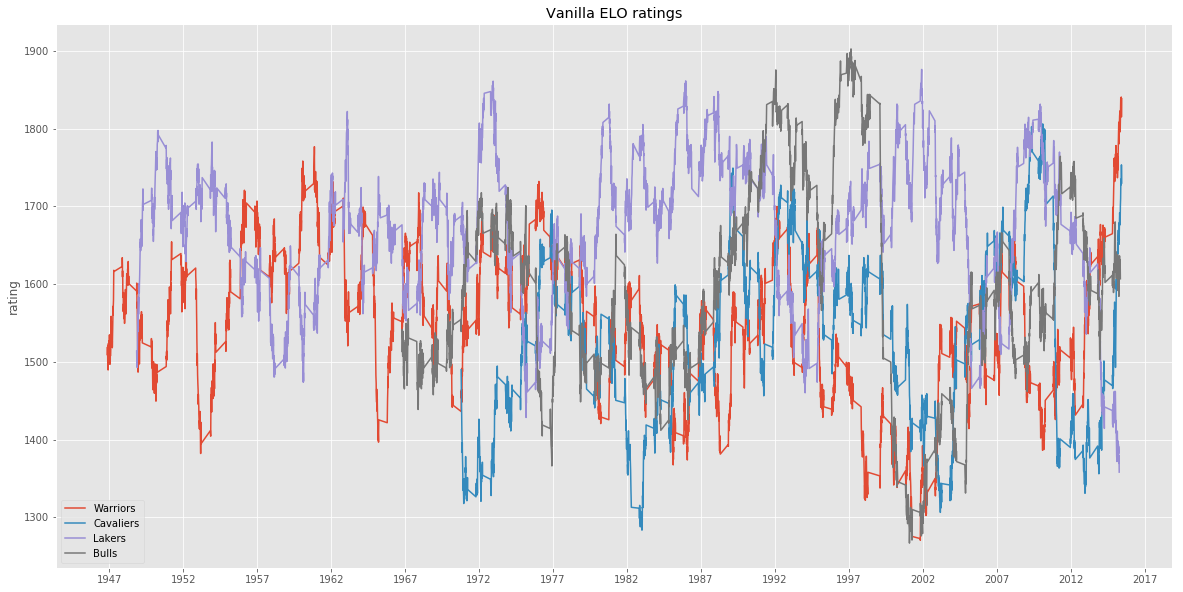

In [21]:
plt.figure(figsize=(20, 10))

plot_ratings(df_data, vanilla_elo, "Warriors")
plot_ratings(df_data, vanilla_elo, "Cavaliers")
plot_ratings(df_data, vanilla_elo, "Lakers")
plot_ratings(df_data, vanilla_elo, "Bulls")

plt.ylabel("rating")
plt.title("Vanilla ELO ratings")
plt.xticks(map(str, range(1947, 2018, 5)))
plt.legend(loc="lower left");

### Stepping up - point differential.
Vanilla ELO does not account for the spread or home advantage. Next up, accounting for the spread.

In [22]:
df_points = raw_data[[u'gameorder', u'game_id', u'lg_id', u'_iscopy', u'year_id',
       u'date_game', u'seasongame', u'is_playoffs', u'team_id', u'fran_id',
       u'pts', u'opp_id', u'opp_fran',
       u'opp_pts', u'game_location',
       u'game_result']][raw_data._iscopy==0].copy()

**Finding the correct strategy for scaling the k-factor is important. You want to keep the margin in mind while re-calculating the elo ratings, but if a very good team beats a poor one by a large margin, then it's effect on the rating should not be huge.** 

Plotting the spread distribution.
Spread mean: 10.7615466219


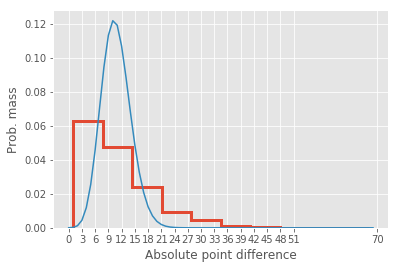

In [23]:
print "Plotting the spread distribution."
df_points["spread"] = np.abs(df_points.pts - df_points.opp_pts)
plt.hist(df_points.spread, bins=10, histtype="step", linewidth=3, normed=True)

from scipy.stats import poisson
print "Spread mean:", df_points.spread.mean()

plt.xticks(range(0, 52, 3) + [70])
plt.xlabel("Absolute point difference")
plt.ylabel("Prob. mass");

d10 = poisson(10.76154)
plt.plot(range(70), d10.pmf(range(70)));

In [24]:
def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

Text(0.5,0,u'Absolute point difference')

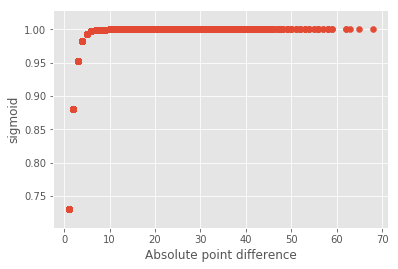

In [25]:
plt.scatter(np.abs(df_points.spread), sigmoid(np.abs(df_points.spread) ))
plt.ylabel("sigmoid")
plt.xlabel("Absolute point difference")

Text(0.5,0,u'Absolute point difference')

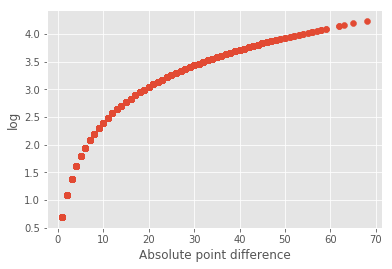

In [26]:
plt.scatter(np.abs(df_points.spread), np.log(np.abs(df_points.spread) + 1.0))
plt.ylabel("log")
plt.xlabel("Absolute point difference")

In [27]:
df_data["elo_diff"] = df_data.new_fran_elo - df_data.new_opp_elo

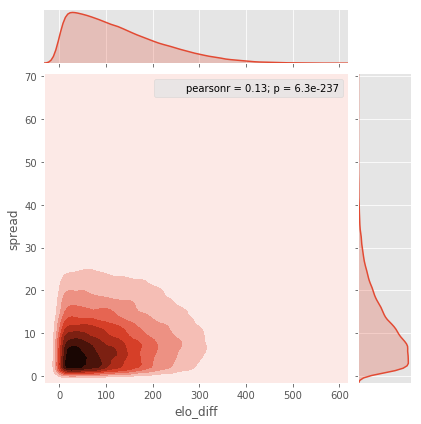

In [28]:
sns.jointplot(np.abs(df_data.elo_diff), np.abs(df_points.spread), kind="kde");

The `log` transform seems to work. Directly multiplying that with the k-factor will account for the margin of victory. What this does not account for is the domanance of one team over the other. That has to be some function of the elo difference. Specifically, if the champions (with an extremely high elo rating; 1996-1997 Bulls) sweep the last standing team before the playoffs (think pre 2017 busting Lakers) then the Bulls should not be awarded a huge factor JUST BECAUSE THEY SWEPT THE LAKERS. However, if the Laksers were to beat the Bulls, then they should get a bigger reward for the upset reflected in the point differential. Such a strategy will prevent a favourite's rating from being inflated.

In [29]:
diff = 500
pointdiff = 20
scaling = np.log(pointdiff+1)

def scale_mov(elodiff, pointdiff):
    return np.log(np.abs(pointdiff) + 1) * (2.5 / (elodiff*0.001 + 5))

In [30]:
scale_mov(500, 20), scale_mov(-500, 20)

(1.3838738353288287, 1.6914013542907906)

In [31]:
print "New updates"
print "Bulls win by 20:", update_elo(1800, 1300, 1, k=(20*scale_mov(500, 20)) )
print "Lakers win by 10:", update_elo(1800, 1300, 0, k=(20*scale_mov(-500, 10)) )

New updates
Bulls win by 20: (1801.473554816107, 1298.526445183893)
Lakers win by 10: (1774.7752131950815, 1325.2247868049185)


In [32]:
print "Without scaling"
print "Bulls win by 20:", update_elo(1800, 1300, 1, k=20*np.log(20+1) )
print "Lakers win by 10:", update_elo(1800, 1300, 0, k=20*np.log(10+1) )

Without scaling
Bulls win by 20: (1803.2418205954357, 1296.7581794045643)
Lakers win by 10: (1754.5953837511465, 1345.4046162488535)


In [33]:
print "Without margins"
print "Bulls win by 20:", update_elo(1800, 1300, 1, )
print "Lakers win by 5:", update_elo(1800, 1300, 0, )

Without margins
Bulls win by 20: (1801.0648043040405, 1298.9351956959595)
Lakers win by 5: (1781.0648043040405, 1318.9351956959595)


Notice that the mov scaling for an favourite does not drasitcally change the updated elo rating for a sweep: new ratings for Bulls with scaling is 1801.47 and vanilla is 1801.06.

The impact is observed during a massive upset. If the Lakers win by 10, then they get a bigger update using the mov-scaling: 1325 as opposed to 1318.

It's interesting to note that the 2nd factor in the `def scale_mov` function almost acts like a beta estimate of the elo difference; that is to say: okay, given that we know that these two teams are pretty far apart in their ratings, should I really award a huge update to either? The logic is that for two teams who have established ratings after consistent performances, a sweep should be routine and thus should have no effect on the updates. Similarly, an upset b/w to two should be dismissed as a fluke.

This behaviour can be controlled, to some capacity, by that 2nd factor in the `def scale_mov` function. The more you increase the denominator(add to 5), the harder it will be for an underdog to get a bigger update EVEN after pulling off a big upset win. 

Part of this is due to the nature of elo updates. By design, elo only looks at the previous ratings, and calculates the expected value of winning based on that. This is also why people go to great lengths for selecting a good k-factor: a common strategy is to have a larger k-factor in the beginning since updating ratings with a very small factor will take time to reflect the true ratings. However, since a large k-factor will lead to volatility, people scale down the k-factor as time passes(or after n games). 

In [34]:
df_points["game_datetime"] = df_points.date_game.map(string_to_datetime)

In [35]:
df_points["prev_fran_elo"] = 0.0
df_points["prev_opp_elo"] = 0.0
df_points["new_fran_elo"] = 0.0
df_points["new_opp_elo"] = 0.0

In [36]:
points_elo = defaultdict(list)
for fran in teams:
    points_elo[fran].append(1500)

In [38]:
_StartTime = time()
_counter = 0
for ix,row in df_points.sort_values("game_datetime").iterrows():
    _counter += 1
    if _counter%5000==0:
        print "Completed %d games."%_counter
    
    outcome = 1 if row["game_result"]=='W' else 0
    
    fran, opp = row["fran_id"], row["opp_fran"]
    prev_fran_elo, prev_opp_elo = points_elo[fran][-1], points_elo[opp][-1]
    
    new_fran_elo, new_opp_elo = update_elo(prev_fran_elo, prev_opp_elo, outcome, 
                                           k=20*scale_mov(elodiff=prev_fran_elo-prev_opp_elo, 
                                                          pointdiff=row["spread"]))
    points_elo[fran].append(new_fran_elo)
    points_elo[opp].append(new_opp_elo)
    
    df_points.loc[ix, "prev_fran_elo"] = prev_fran_elo
    df_points.loc[ix, "prev_opp_elo"] = prev_opp_elo
    
    df_points.loc[ix, "new_fran_elo"] = new_fran_elo
    df_points.loc[ix, "new_opp_elo"] = new_opp_elo

print "Completed %d games."%_counter
print "\nDone.", "Time :", (time()-_StartTime)/60.0

Completed 5000 games.
Completed 10000 games.
Completed 15000 games.
Completed 20000 games.
Completed 25000 games.
Completed 30000 games.
Completed 35000 games.
Completed 40000 games.
Completed 45000 games.
Completed 50000 games.
Completed 55000 games.
Completed 60000 games.
Completed 63157 games.

Done. Time : 2.46398250262


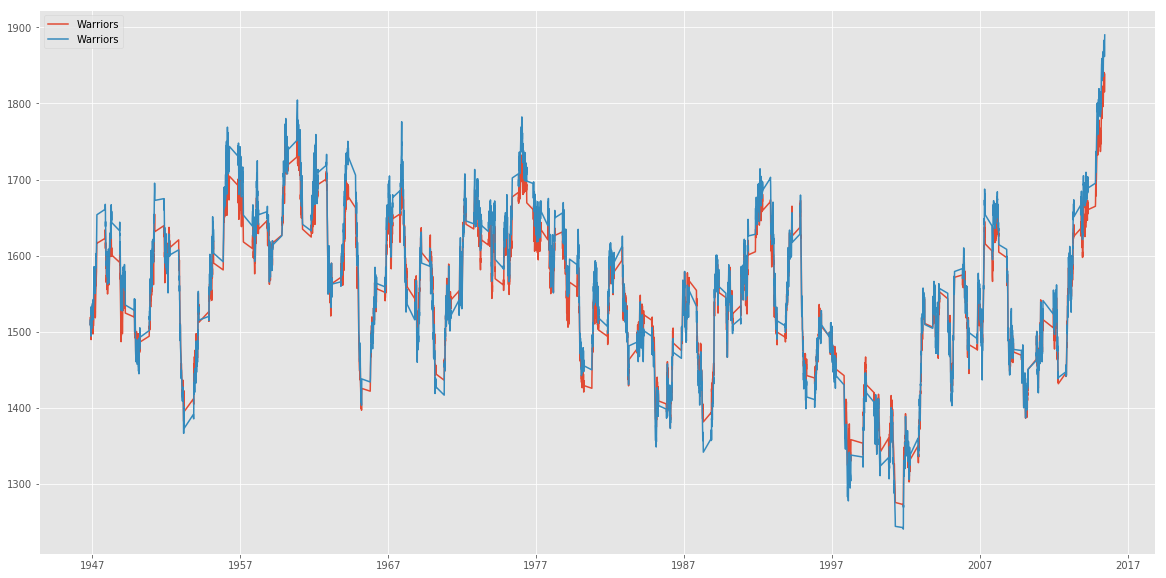

In [42]:
plt.figure(figsize=(20, 10))

plot_ratings(df_data, vanilla_elo, "Warriors")
plot_ratings(df_points, points_elo, "Warriors")
# plt.plot(df_points[(df_points.fran_id=="Warriors") | (df_points.opp_fran=="Warriors")]["game_datetime"],
#         points_elo["Warriors"][1:], label="Warriors-mov")
# plt.plot(df_points[(df_points.fran_id=="Cavaliers") | (df_points.opp_fran=="Cavaliers")]["game_datetime"],
#         points_elo["Cavaliers"][1:], label="Cavaliers-mov")


plt.legend()

### Adding home-court advantage.